In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
# import vegas
# import pandas as pd

# constants
M_sun = 1.9891e30 # solar mass in kg
yr2s = 31556926 # year in seconds
G = 6.67430e-11 # Newton gravity constant, m^3/kg/s^2
mp = 1.6726e-27 # proton mass, kg
kB = 1.38064e-23 # Boltzman constant, m^2 kg /s^2 /K
K2MeV = 1000 / 1.161e13 # Kelvin to MeV
K2erg = 1.3806e-16 # Kelvin to erg
MeV2kg = 1.783e-30 # MeV to kg
light_speed = 29979245800 # cm/s
M_sun_erg = 1.79e54 # solar mass to erg
g2erg = 8.987e20 # 1 gram to erg

# Preparing python dicts for different SN profiles
path_dict = {'LS220':'LS220-s18.88/','TF':'TF-10.8/','SFHo':'SFHo-18.8/'}
eps_dict = {'1e-11':1e-11,'1e-13':1e-13}

# LS220-s18.88
time_LS220 = np.array([0.025025958, 0.049998391, 0.074824948, 0.099864677, 0.12498343,0.1500311, 0.17509553, 0.20019816, 0.2248337, 0.24981552, 0.2748468,0.29991753, 0.32495867, 0.35001769, 0.37515225, 0.40005328,0.42519939, 0.44975758, 0.47488252, 0.50006312, 0.75020978,0.99981123, 1.2499211, 1.4998553, 1.7498401, 2.0001881, 2.2500268,2.5001422, 2.7499499, 3.0002358, 3.4997695, 4.0000049, 4.4997671,5.0000058, 5.5001784, 6.0000124, 7.0000407, 8.0001427, 8.9999821,9.9998723, 11.000235])
# TF-10.8
time_TF = np.array([0.0, 0.0005071633749998972, 0.001344984198914295, 0.002747482114197092, 0.005360368439765006, 0.009114730681676703, 0.01546656236520411, 0.02377903315351249, 0.0371038998588703, 0.07270743901011611, 0.1559318935712961, 0.1984338428379552, 0.2355246646583827, 0.2696407132612904, 0.2987081452406821, 0.3220030873362578, 0.3494485917853219, 0.4321251343862368, 0.6345777798749864, 0.8290217158061605, 1.148255042476532, 1.530587216869893, 1.850095515413669, 2.025641464550373, 2.291022256907176, 2.494024409449831, 2.776469255304346, 3.069363525669363, 3.181757573705697, 3.38167350130409, 3.589134145372821, 3.911817883753428, 4.300552294421064, 4.685719134837941, 4.982012461146646, 5.268128531663336, 5.64828123539431, 6.108655871270188, 6.606821133770339, 7.106768633770505, 7.606768633770672, 7.636883658096388, 7.646664932038442, 7.660086480352283, 7.666737588615097, 7.690023524550349, 7.82354227734557, 7.828542277345381, 7.833542277345192, 7.838542277345002, 7.844106817969775, 7.849128187336813, 7.854128187336624, 7.859216708957359, 8.070953649197923, 8.527035413357245, 9.013405594743654, 9.50413538884011, 10.00263288883984, 10.49505799144959]) 
# SFHo-18.8
time_SFHo = np.array([0.025059213, 0.05011927, 0.074826743, 0.09983578, 0.12485604, 0.14986846, 0.17488231, 0.19989878, 0.22491674, 0.24993268, 0.25008736, 0.2749493, 0.30021245, 0.32521253, 0.35011666, 0.37512281, 0.40013599, 0.42514829, 0.45015242, 0.47516306, 0.5001775, 0.74987351, 1.0002234, 1.2500327, 1.4997635, 1.749857, 2.0001179, 2.2501048, 2.5002329, 2.7502406, 3.0001038, 3.4998576, 4.0000753, 4.4999348, 5.0000931, 5.5000477, 5.9999425, 6.9999881, 8.0001694, 8.9998587, 10.000057])
time_dict = {'LS220':time_LS220,
             'TF':time_TF,
             'SFHo':time_SFHo}

number_of_r = 41
number_of_mAp = 91

# Load CSM data
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_data = np.loadtxt('CSM_density/SN2023ixf.txt').T
rho_interp = interp1d(np.log10(rho_data[0]),np.log10(rho_data[1]),
                      kind='cubic',
                      bounds_error=False,
                      fill_value=0) # log scale interp
r_max = rho_data[0][-1]
r_min = rho_data[0][0]
def CSM_density(r):
    """
    g/cm^3
    """
    r = np.log10(r)
    return 10**rho_interp(r)

In [2]:
def fname(time,eps,SN_profile):
    fn_ret_dict = {'LS220':f'timeprofile_{time:d}_eps_{eps:.0e}_more.dat',
               'TF':f'timeprofile_{time:d}_eps_{eps:.0e}_more_TF.dat',
               'SFHo':f'timeprofile_{time:d}_eps_{eps:.0e}_SFHo_more.dat'}
    fn_adv_dict = {'LS220':f'timeprofile_{time + 1:d}_eps_{eps:.0e}_more.dat',
               'TF':f'timeprofile_{time + 1:d}_eps_{eps:.0e}_more_TF.dat',
               'SFHo':f'timeprofile_{time + 1:d}_eps_{eps:.0e}_SFHo_more.dat'}
    return fn_ret_dict[SN_profile],fn_adv_dict[SN_profile]

### Trapezoidal Rule
I use trapezoidal rule to do the time integration,
$$
\frac{dL}{dr} = \int_{t_{\rm min}}^{t_{\rm max}} dt~\frac{dL}{dt dr} = \frac{1}{2}\sum_{i=0}^{40} \left[\frac{dL}{dt dr}(t_{i+1})+\frac{dL}{dt dr}(t_i)\right] \Delta t
$$
where $\Delta t =t_{i+1}-t_{i}$.

In [60]:
# Specify SN profile & eps
SN_profile = 'TF' # 'LS220', 'TF', 'SFHo'
eps = '1e-11' # '1e-13'

# Specify file path, epsilon & time list
path = path_dict[SN_profile]
eps = eps_dict[eps]
time_list = time_dict[SN_profile]
number_of_time_steps = len(time_list)

dQ_int = np.zeros(number_of_r * number_of_mAp) # how many rows of dQ

for time in range(number_of_time_steps - 1):
    fn_ret,fn_adv = fname(time,eps,SN_profile) # file name

    data_retard = np.loadtxt(path + fn_ret)  # data at time_id
    data_advanced = np.loadtxt(path + fn_adv)  # data at (time_id + 1)
    
    # dL at time_id
    dQ_T_retard = data_retard[:,3]
    dQ_L_retard = data_retard[:,4]
    dQ_tot_retard = dQ_T_retard + dQ_L_retard # sum over polarizations
    
    # dL at (time_id + 1)
    dQ_T_advanced = data_advanced[:,3]
    dQ_L_advanced = data_advanced[:,4]
    dQ_tot_advanced = dQ_T_advanced + dQ_L_advanced # sum over polarizations
    
    # Delta t
    dt = time_list[time + 1] - time_list[time]
    
    # time integration at this Delta t
    dQ_int += (dQ_tot_advanced + dQ_tot_retard) * dt
dQ_int = dQ_int / 2 # trapezoid area

# Replace T, L polarizations different time steps with time-integrated value
data_time_int = np.hstack(((data_retard.T[:3]).T, dQ_int.reshape(-1,1)))
# Save data
np.savetxt(path + 'time_integrated/time_int_eps_' + str(eps) + '.txt',data_time_int,fmt='%.5e',header = 'mAp [MeV]  epsilon []  r [cm]  (dQ/drdt)*dt [erg/cm]')

### Energy deposition
To get the energy deposition $Q$ of DP, we integrate over $r$
$$
Q(\epsilon) =\int_{r_{\rm min}}^{r_{\rm max}}\frac{dQ}{dr}(\epsilon,r)
$$
where $dQ/dr$ for arbitrary $(\epsilon,r)$ can be scaled from a reference $dQ/dr$ derived at $\epsilon_0$,
$$
\frac{dQ}{dr}(\epsilon,r)=\left(\frac{\epsilon}{\epsilon_{0}}\right)^{4}\frac{dQ}{dr}(\epsilon_{0},(\epsilon/\epsilon_{0})^{2}r)
$$

In [62]:
# To run the following function, it requires time-integrated dQ is evaluated already

def total_energy_deposition(mAp_i,r_min,r_max,eps_list = [1e-11],SN_profile='LS220'):
    """
    In
    ---
    mAp_i : the i-th mAp mass, total 91 mAp masses are calculated, int
    r_min : minimum radius for energy depostion, cm 
    r_max : maximum radius for energy depostion, cm
    eps_list : a list of epsilon to be evaluated for energy deposition

    Out
    ---
    Q : total energy deposition, r
    """
    # Grid number of CSM radius in (1e12,1e20) cm in log-scale
    r_grids = 41
    # Load time-integrated data
    path = path_dict[SN_profile]
    data_eps_1e_minus_13 = np.loadtxt(path + 'time_integrated/time_int_eps_1e-13.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-13
    data_eps_1e_minus_11 = np.loadtxt(path + 'time_integrated/time_int_eps_1e-11.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-11
    
    # Data arrangement
    mAp_mass = data_eps_1e_minus_13[1,0]
    log_r = data_eps_1e_minus_13[:,2]
    dQ_time_int_1e_minus_13_log10 = np.log10(data_eps_1e_minus_13[:,3]) # log10(energy deposition) for eps = 1e-13
    dQ_time_int_1e_minus_11_log10 = np.log10(data_eps_1e_minus_11[:,3]) # log10(energy deposition) for eps = 1e-11
    # interpolation
    dQ_minus_13_log10 = interp1d(log_r,dQ_time_int_1e_minus_13_log10)
    dQ_minus_11_log10 = interp1d(log_r,dQ_time_int_1e_minus_11_log10)
    dQ_minus_13 = lambda r: 10**dQ_minus_13_log10(np.log10(r))
    dQ_minus_11 = lambda r: 10**dQ_minus_11_log10(np.log10(r))

    # dL for arbitrary eps and r
    def dQ(eps,r):
        try:
            # try reference eps = 1e-11 first
            scaling = (eps / 1e-11)**4
            r_p = (eps / 1e-11)**2 * r
            return scaling * dQ_minus_11(r_p)
        except:
            # try reference eps = 1e-13
            scaling = (eps / 1e-13)**4
            r_p = (eps / 1e-13)**2 * r
            return scaling * dQ_minus_13(r_p)

    energy_dep_list = []
    for eps in eps_list:
        energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
        energy_dep_list.append(energy_dep)
    return energy_dep_list

In [69]:
# Calculate energy deposition
SN_profile = 'SFHo'
eps_list = np.logspace(-13.5,-10,100)

energy_dep_grid = []
for i in range(number_of_mAp):
    ene_dep = total_energy_deposition(i,r_min,r_max,eps_list = eps_list,SN_profile=SN_profile)
    energy_dep_grid.append(ene_dep)
energy_dep_grid = np.array(energy_dep_grid).T
np.savetxt(path_dict[SN_profile] + 'Q_tot/Q_tot.txt',energy_dep_grid,fmt='%5e')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_42863/1808155019.py:49: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_42863/1808155019.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]


### Constraints

This part requires the energy depostion $Q$ is finished.

In [71]:
# Load total energy deposition data and taking log10
log_Q_tot_LS220 = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot.txt')/2)
log_Q_tot_TF = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot.txt')/2)
log_Q_tot_SFHo = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot.txt')/2)

# Preparing axis values
mAp_axis = np.logspace(0,np.log10(501.1872),91)
eps_axis = np.logspace(-13.5,-10,100)
mAp_mesh,eps_mesh = np.meshgrid(mAp_axis,eps_axis)

# Load SN1987a gamma-ray constraint
sn1987a_gamma_data = np.loadtxt('sn1987a_gamma.txt')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_42863/1109415856.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM = 4*np.pi*quad(lambda r: r**2 * CSM_density(r),r_min,r_max,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_42863/1109415856.py:14: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_LS220.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ip

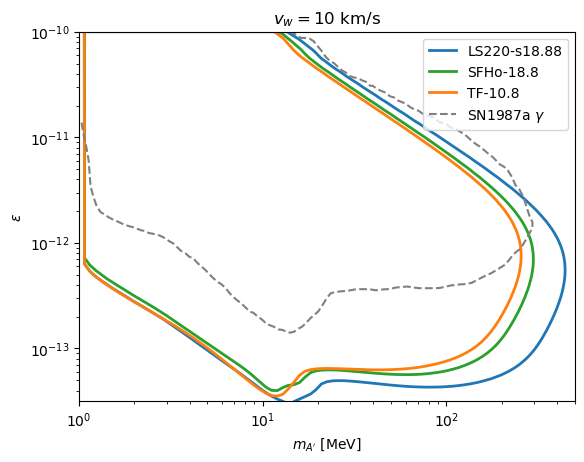

In [77]:
v_csm = 10 # km/s
M_CSM = 4*np.pi*quad(lambda r: r**2 * CSM_density(r),r_min,r_max,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
Q_th = np.log10((v_csm*1e5/light_speed)**2*M_CSM/2)

# contour_SFHo = plt.contourf(X_mesh, Y_mesh, Z, 
#                            levels=20, 
#                            cmap='viridis',
#                            )

target_contour_LS220 =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220, 'r:', levels=[Q_th], linewidths=0)
target_contour_TF =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_TF, 'r:', levels=[Q_th], linewidths=0)
target_contour_SFHo =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo, 'r:', levels=[Q_th], linewidths=0)

for collection in target_contour_LS220.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
plt.title(fr'$v_w={v_csm:d}$ km/s')
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{A^\prime}$ [MeV]')
plt.ylabel(r'$\epsilon$')
plt.ylim(3.16e-14,1e-10)
plt.savefig(f'DP_constraint_vw{v_csm:d}.pdf',bbox_inches='tight')

In [32]:
10**(-13.5)

3.1622776601683796e-14